In [28]:
from fastai.vision.all import *
from fastai.learner import *
from fastai.data.all import *
from fastai.callback.tracker import SaveModelCallback
import pandas as pd
import matplotlib.pyplot as plt
from pathlib2 import Path
import numpy as np
import random
from torch.nn import MSELoss

You can download the ebooks [here](https://www.openslr.org/resources/12/original-books.tar.gz).

We will need the pretrained embeddings from https://github.com/iamyuanchung/speech2vec-pretrained-vectors. We will use them to compare our results and also to figure out what vocab the authors of the speech2vec paper used for training. Let us start with the latter.

In [29]:
import logging
from six import iteritems
from web.datasets.similarity import fetch_MEN, fetch_WS353, fetch_SimLex999
from web.embeddings import fetch_GloVe
from web.evaluate import evaluate_similarity
from web.embedding import Embedding, Vocabulary
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [30]:
starting_lines = {
    '1004/1004.txt.utf-8': 535,
    '10123/10123.txt.utf-8': 85,
    '10359/10359.txt.utf-8': 76,
    '10360/10360.txt.utf-8': 57,
    '10378/10378.txt.utf-8': 96,
    '10390/10390.txt.utf-8': 89,
    '1193/1193.txt.utf-8': 272,
    '12441/12441-0.txt': 101,
    '1249/1249.txt.utf-8': 614,
    '1325/1325.txt.utf-8': 434,
    '1674/1674.txt.utf-8': 360,
    '2046/2046.txt.utf-8': 295,
    '2147/2147.txt.utf-8': 66,
    '2184/2184.txt.utf-8': 302,
    '2383/2383.txt.utf-8': 408,
    '2486/2486.txt.utf-8': 293,
    '2488/2488.txt.utf-8': 495,
    '2512/2512-0.txt': 113,
    '2515/2515.txt.utf-8': 281,
    '2678/2678.txt.utf-8': 305,
    '2679/2679.txt.utf-8': 308,
    '269/269-0.txt': 67,
    '282/282-0.txt': 43,
    '2891/2891.txt.utf-8': 336,
    '3053/3053.txt.utf-8': 340,
    '3169/3169.txt.utf-8': 386,
    '325/325.txt.utf-8': 170,
    '3300/3300.txt.utf-8': 40,
    '34757/34757-0.txt': 185,
    '3604/3604.txt.utf-8': 612,
    '3623/3623.txt.utf-8': 342,
    '3697/3697.txt.utf-8': 449,
    '37660/37660-0.txt': 74,
    '4028/4028.txt.utf-8': 402,
    '4042/4042.txt.utf-8': 438,
    '435/435.txt.utf-8': 62,
    '6456/6456.txt.utf-8': 53,
    '7098/7098.txt.utf-8': 77,
    '76/76.txt.utf-8': 579,
    '778/778.txt.utf-8': 297,
    '786/786-0.txt': 158,
}   

In [31]:
%%time

texts = []

for fn, starting_line in starting_lines.items():
    with open(f'data/books/LibriSpeech/books/utf-8/{fn}') as file:
        lines = file.readlines()[starting_line:]
        texts.append(' '.join(lines))

CPU times: user 76 ms, sys: 64 ms, total: 140 ms
Wall time: 139 ms


In [32]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [33]:
len(texts)

41

In [53]:
docs = nlp.tokenizer.pipe(texts, batch_size=10)

In [54]:
words = []
for doc in docs:
    words += [token.text.lower() for token in doc if token.is_alpha]

In [55]:
speech2vec = KeyedVectors.load_word2vec_format('../speech2vec-pretrained-vectors/speech2vec/50.vec', binary=False) 

vocab = set(speech2vec.vocab.keys())
len(vocab)

37622

In [56]:
%%time

word_pairs = []

docs = nlp.tokenizer.pipe(texts, batch_size=10)
for doc in docs:
    words = [token.text.lower() for token in doc if token.is_alpha]
    words = [w if w in vocab else '<UNK>' for w in words]
    
    for i, word in enumerate(words):
        if word == '<UNK>': continue
        for offset in [-2, -1, 1, 2]:
            if i + offset < 0 or i + offset >= len(words): continue
            target_word = words[i+offset]
            if target_word == '<UNK>': continue
            word_pairs.append([word, target_word])

CPU times: user 50.3 s, sys: 1.16 s, total: 51.5 s
Wall time: 51.5 s


In [57]:
len(word_pairs)

14129050

In [58]:
word_pairs[:20]

[['midway', 'upon'],
 ['midway', 'the'],
 ['upon', 'midway'],
 ['upon', 'the'],
 ['upon', 'journey'],
 ['the', 'midway'],
 ['the', 'upon'],
 ['the', 'journey'],
 ['the', 'of'],
 ['journey', 'upon'],
 ['journey', 'the'],
 ['journey', 'of'],
 ['journey', 'our'],
 ['of', 'the'],
 ['of', 'journey'],
 ['of', 'our'],
 ['of', 'life'],
 ['our', 'journey'],
 ['our', 'of'],
 ['our', 'life']]

In [59]:
vocab = list(vocab)
word2index = {w: i for i, w in enumerate(vocab)}

In [60]:
class Dataset():
    def __init__(self, pairs):
        self.pairs = pairs
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        source_word, target_word = self.pairs[idx]
        return word2index[source_word], word2index[target_word]

In [61]:
train_ds = Dataset(word_pairs[:14_000_000])
valid_ds = Dataset(word_pairs[14_000_000:])

In [62]:
len(train_ds), len(valid_ds)

(14000000, 129050)

In [63]:
BS = 2048
NUM_WORKERS = 8

train_dl = DataLoader(train_ds, BS, NUM_WORKERS, shuffle=True)
valid_dl = DataLoader(valid_ds, BS, NUM_WORKERS)

dls = DataLoaders(train_dl, valid_dl)

In [64]:
class Model(Module):
    def __init__(self, hidden_size=50):
        self.embeddings =nn.Embedding(len(vocab), hidden_size)
        self.linear = nn.Linear(hidden_size, len(vocab))
            
    def forward(self, x):
        x = self.embeddings(x)
        return self.linear(x)

In [65]:
learn = Learner(
    dls.cuda(),
    Model().cuda(),
    loss_func=CrossEntropyLossFlat(),
    opt_func=Adam,
    metrics=[accuracy]
)

In [66]:
NUM_EPOCHS = 120
learn.fit(NUM_EPOCHS, lr=1e-3, cbs=SaveModelCallback(fname='text_embeddings', every_epoch=True))

epoch,train_loss,valid_loss,accuracy,time
0,6.661907,6.566479,0.058063,01:48
1,6.611614,6.492751,0.061813,01:46
2,6.559349,6.454994,0.064060,01:47
3,6.550567,6.434625,0.064099,01:46
4,6.527991,6.415623,0.065471,01:49
5,6.514022,6.404819,0.066261,01:49
6,6.497787,6.393661,0.066176,01:38
7,6.493157,6.382494,0.066935,01:38
8,6.484284,6.375274,0.067687,01:38
9,6.466319,6.369371,0.067873,01:38


## Evalute embeddings

In [67]:
from utils import Embeddings

In [68]:
embeddings = learn.model.embeddings.weight.cpu().detach().numpy()

In [69]:
e = Embeddings(
    embeddings,
    vocab
)

In [70]:
for w in ['fast', 'lost', 'small', 'true', 'crazy', 'slow']:
    print(f'{w}: {e.nn_words_to(e[w])}')

fast: ['fast', 'swiftly', 'lustily', 'furiously', 'docile']
lost: ['lost', 'regained', 'hardening', 'stilled', 'dreamed']
small: ['small', 'large', 'tiny', 'big', 'huge']
true: ['true', 'mors', 'virtuous', 'sooth', 'truest']
crazy: ['crazy', 'pap', 'jim', 'cheerily', 'finn']
slow: ['slow', 'swift', 'rapid', 'noisy', 'gradual']


## Evaluating embeddings using [word-embeddings-benchmarks](https://github.com/kudkudak/word-embeddings-benchmarks)

In [71]:
import logging
from six import iteritems
from web.datasets.similarity import fetch_MEN, fetch_WS353, fetch_SimLex999
from web.embeddings import fetch_GloVe
from web.evaluate import evaluate_similarity
from web.embedding import Embedding, Vocabulary
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [72]:
tasks = {
    "MEN": fetch_MEN(),
    "WS353": fetch_WS353(),
    "SIMLEX999": fetch_SimLex999()
}

In [73]:
our_embeddings = Embedding(
    Vocabulary(vocab),
    embeddings
)

speech2vec = KeyedVectors.load_word2vec_format('../speech2vec-pretrained-vectors/word2vec/50.vec', binary=False) 
speech2vec_embeddings = Embedding(Vocabulary(list(speech2vec.vocab.keys())), speech2vec.vectors)

In [74]:
for name, data in iteritems(tasks):
    print("Spearman correlation of scores on {} {}".format(name, evaluate_similarity(our_embeddings, data.X, data.y)))

Missing 392 words. Will replace them with mean vector
/opt/conda/lib/python3.7/site-packages/web-0.0.1-py3.7.egg/web/evaluate.py:336: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  A = np.vstack(w.get(word, mean_vector) for word in X[:, 0])
/opt/conda/lib/python3.7/site-packages/web-0.0.1-py3.7.egg/web/evaluate.py:337: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  B = np.vstack(w.get(word, mean_vector) for word in X[:, 1])
Missing 61 words. Will replace them with mean vector
Missing 24 words. Will replace them with mean vector


Spearman correlation of scores on MEN 0.41874461355141807
Spearman correlation of scores on WS353 0.2889747942907207
Spearman correlation of scores on SIMLEX999 0.18706038378173265


In [75]:
for name, data in iteritems(tasks):
    print("Spearman correlation of scores on {} {}".format(name, evaluate_similarity(speech2vec_embeddings, data.X, data.y)))

Missing 392 words. Will replace them with mean vector
Missing 61 words. Will replace them with mean vector
Missing 24 words. Will replace them with mean vector


Spearman correlation of scores on MEN 0.6056592803599269
Spearman correlation of scores on WS353 0.43349390636024643
Spearman correlation of scores on SIMLEX999 0.25938770901422736


## Loss decrease and improvements on semantic tasks as training progresses

In [76]:
%%capture

val_losses, accuracies, task_perf = [], [], []
for i in range(NUM_EPOCHS):
    learn.load(f'text_embeddings_{i}')
    loss, accuracy = learn.validate()
    val_losses.append(loss)
    accuracies.append(accuracy)
    
    embeddings = learn.model.embeddings.weight.cpu().detach().numpy()
    our_embeddings = Embedding(
        Vocabulary([w.lower() for w in vocab]),
        embeddings
    )

    task_perf.append([evaluate_similarity(our_embeddings, data.X, data.y) for name, data in iteritems(tasks)])

In [77]:
men, ws353, simlex999 = list(zip(*task_perf))

In [78]:
import matplotlib.pyplot as plt

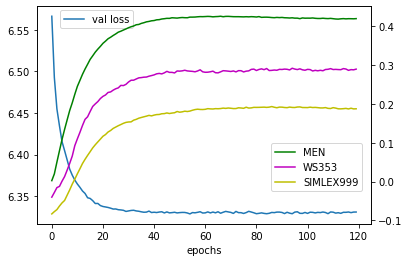

In [79]:
fig, ax1 = plt.subplots()

ax1.plot(val_losses, label='val loss')

ax2 = ax1.twinx()
ax2.plot(men, label='MEN', c='g')
ax2.plot(ws353, label='WS353', c='m')
ax2.plot(simlex999, label='SIMLEX999', c='y')

ax1.legend(loc=[0.07, 0.9])
ax2.legend(loc=[0.7, 0.15])

ax1.set_xlabel('epochs');